## Лабораторная 3: метод ближайших соседей (kNN)

В рамках этого занятия мы будем создавать модель для предсказания выживших пассажиров на "Титанике" (классическое учебное Kaggle [соревнование](https://www.kaggle.com/c/titanic)).

![Титаник](http://staff.mmcs.sfedu.ru/~sguda/MachineLearning/titanic.png)

## 1

Загрузите данные о погибших в катастрофе с "Титаником". Целевым признаком здесь является факт спасения пассажира. Посмотрите на данные.

In [ ]:
import pandas as pd

In [ ]:
# место для кода
df = pd.read_csv('data.csv')
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [ ]:
# место для кода

Для простоты исключите пассажиров с неизвестным возрастом и заново перенумеруйте строки

*Функции, которые могут пригодиться при решении: `.dropna(subset=['Age']), .reset_index(drop=True)`*

In [ ]:
df = df.dropna(subset=['Age']) 
df = df.reset_index(drop=True)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
709,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
710,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
711,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
712,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## 2

Постройте график рассеяния с возрастом в качестве оси абсцисс и ценой билета в качестве оси ординат. Отметьте красным — погибших, зеленым — спасшихся пассажиров. Постройте отдельно 2 графика: для женщин и для мужчин. 

Выполняется ли для данного множества гипотеза компактности?

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

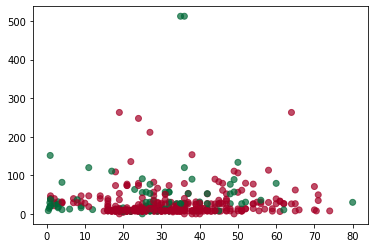

In [ ]:
# место для кода
plt.scatter(df[df['Sex']=='male']['Age'], df[df['Sex']=='male']['Fare'], c=df[df['Sex']=='male']['Survived'], alpha=0.7, cmap='RdYlGn')

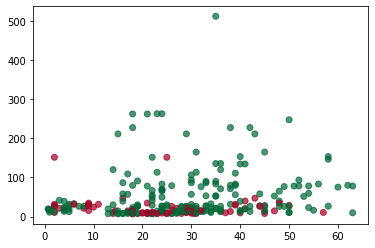

In [ ]:
# место для кода
plt.scatter(df[df['Sex']=='female']['Age'], df[df['Sex']=='female']['Fare'], c=df[df['Sex']=='female']['Survived'], alpha=0.7, cmap='RdYlGn')

## 3 

Для построения модели нам понадобится метрика близости пассажиров. Запрограммируем функцию вычисления расстояния между пассажирами:

In [ ]:
def distance(a,b):
    d = 0
    d += abs(a['Pclass'] - b['Pclass'])
    d += a['Sex'] != b['Sex']
    d += abs(a['Age'] - b['Age'])
    d += abs(a['SibSp'] - b['SibSp'])
    d += abs(a['Parch'] - b['Parch'])
    d += abs(a['Fare'] - b['Fare'])
    d += a['Embarked'] != b['Embarked']
    return d

Метод `KNeighborsClassifier` из библиотеки `sklearn` излишне требователен к типам данных. Запрограммируем метод `k` ближайших соседей вручную:

In [ ]:
import numpy as np
import tqdm

In [ ]:
def myKNeighborsClassifier(learnData, K, passengerIndexForPrediction):
    dists = np.zeros((learnData.shape[0] - 1, 2))
    i = 0
    for idx, row in learnData.iterrows():
        if idx != passengerIndexForPrediction:  #LOO метод контроля ошибки
            dists[i][0] = distance(learnData.loc[passengerIndexForPrediction,], row)
            dists[i][1] = row['Survived']
            i += 1
    dists = sorted(dists, key = lambda pair: pair[0])
    prediction = 0
    for i in range(K): 
        prediction += dists[i][1]
    prediction /= K
    return round(prediction)

Запустите предсказание для всех пассажиров судна и, используя LOO-контроль ошибки оцените качество классификации:

In [ ]:
accuracy = 0
for idx, row in tqdm.tqdm(df.iterrows(), total=len(df)):
    accuracy += row['Survived'] == myKNeighborsClassifier(df, 5, idx)
print(accuracy/df.shape[0])

100%|██████████| 714/714 [03:49<00:00,  3.11it/s]

0.726890756302521


Подберите слагаемые в метрике, их веса и количество соседей так, чтобы качество классификации было максимальным. 

Если функция на `python` работает долго, воспользуйтесь ее аналогом на 
С++:  `KNeighborsClassifier.cpp.` 

Компиляция на Linux выполняется командой 

    g++ -O2 KNeighborsClassifier.cpp -o  KNeighborsClassifier


Запуск: 

    ./KNeighborsClassifier
    
Построившему метрику с наилучшим качеством: +5 бонусных баллов.

Компиляция производилась в colabe поэтому через "!", если будете проверять локально, то закомментируйте строку чтобы она не ругалась)   

In [ ]:
!g++ -O2 KNeighborsClassifier.cpp -o  KNeighborsClassifier

Изменения функции расстояния проводились в cpp 

In [321]:
#!g++ -O2 KNeighborsClassifier.cpp -o  KNeighborsClassifier
import subprocess

best_scor = 0
best_k=0
for i in range(1, 10):
     _, scor = subprocess.getstatusoutput('./KNeighborsClassifier ' + str(i) + ' 0.5 1.5 0.1 1.04 0.8 0.3 0')
     if (best_scor<float(scor)):
         best_scor=float(scor)
         best_k=i
print(str(best_k) +' '+ str(best_scor))

3 83.3333


In [317]:
print(subprocess.getstatusoutput('./KNeighborsClassifier ' + str(3) + ' 0.5 1.5 0.1 1.04 0.8 0.3 0'))

(0, '83.3333')


Самый лучший результат 
1.5 Sex + 0.5* Pclass + 0.1* Embarked + 1.04 SibSp + 0.8 Parch + 0.3*Age дает лучший результат (при k = 3 Качество 83.3333%)

## 4

Создайте копию функции `myKNeighborsClassifier` и измените ее так, чтобы она считала выступ объекта. Назовите ее `calcMargin`. 

Вычислите выступы для всех объектов и выведите информацию о пяти объектах с минимальным выступом (шумовых выбросах) и пяти объектах с максимальным выступом (эталонах). Объясните в комментариях полученные данные.

In [ ]:
def calcMargin(learnData, K,  passengerIndexForPrediction):
    dists = np.zeros((learnData.shape[0] - 1, 2))
    
    i = 0
    for idx, row in learnData.iterrows():
        if idx != passengerIndexForPrediction:  #LOO метод контроля ошибки
            dists[i][0] = distance(learnData.loc[passengerIndexForPrediction,], row)
            dists[i][1] = row['Survived']
            i += 1
    dists = sorted(dists, key = lambda pair: pair[0])
    dists = np.array(dists)
    
    
    ans=0
    for i in range(K): 
        if (learnData.loc[passengerIndexForPrediction,]['Survived'] == dists[i][1]):
            ans += dists[i][0]
        else:
            ans -= dists[i][0]
    return np.array([ans, passengerIndexForPrediction])
    
    

In [ ]:
margins = list()
for idx, row in tqdm.tqdm(df.iterrows(), total=len(df)):
    margins.append(calcMargin(df, 5, idx))

100%|██████████| 714/714 [03:05<00:00,  3.85it/s]


In [ ]:
# место для кода
margins = sorted(margins, key = lambda pair: pair[0])
margins = np.array(margins)
idx= margins[:,1]

Это легче всего сделать с помощью функции `np.argsort`, возвращающей индексы элементов в отсортированном ряду:

In [ ]:
# idx = np.argsort(margins)
# print(len(idx))

508368


In [ ]:
print('Белые вороны (аномалии)')
df.loc[idx[:5],]

Белые вороны (аномалии)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
351.0,439,0,1,"Fortune, Mr. Mark",male,64.00,1,4,19950,263.0000,C23 C25 C27,S
301.0,378,0,1,"Widener, Mr. Harry Elkins",male,27.00,0,2,113503,211.5000,C82,C
498.0,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.00,0,0,27042,30.0000,A23,S
298.0,374,0,1,"Ringhini, Mr. Sante",male,22.00,0,0,PC 17760,135.6333,NaN,C
243.0,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S


In [ ]:
print('Эталоны (характерные объекты)')
df.loc[idx[-5:],]

Эталоны (характерные объекты)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
521.0,661,1,1,"Frauenthal, Dr. Henry William",male,50.0,2,0,PC 17611,133.6500,NaN,S
304.0,381,1,1,"Bidois, Miss. Rosalie",female,42.0,0,0,PC 17757,227.5250,NaN,C
208.0,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
587.0,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C
537.0,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
